In [1]:
import os
import ast
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import constants

In [2]:
def summarize(path, fname, name):
    model_meta = pd.read_csv(os.path.join(path, fname))
    def replace(x):
        try:
            return ast.literal_eval(x)
        except:
            return x
    for col in ['train_losses', 'valid_losses']:
        try:
            model_meta[col] = model_meta[col].apply(replace)
        except:
            pass

    model_meta['epochs'] = model_meta['train_losses'].apply(len)
    model_meta['final_train_loss'] = model_meta['train_losses'].apply(lambda x: x[-1])
    model_meta = model_meta.assign(approach=name)

    return model_meta

In [3]:
def read_rnn_results(root_dir, exp_dir):
    args = exp_dir.split('_')[3:]
    df = summarize(os.path.join(root_dir, exp_dir), 'trial_results.csv', 'chan_avg_rnn')

    df = df.assign(hidden_size=int(args[0].split('-')[0]))
    df = df.assign(rnn_layers=int(args[1].split('-')[0]))
    df = df.assign(fc_layers=int(args[2].split('-')[0]))
    if len(args) > 3:
        df = df.assign(bidirectional=True)
    else:
        df = df.assign(bidirectional=False)
    
    return df

In [93]:
all_model_df = pd.DataFrame()

root_dir = os.path.join(constants.RESULTS_DIR,
                        'motor_LR', 'chan_avg_rnn', 'rs',
                        'bandpass_only', 'max_abs_scale', 'gru', '50e_early_stop')
for d in os.listdir(root_dir):
    try:
        df = read_rnn_results(root_dir, d)
        all_model_df = all_model_df.append(df, ignore_index=True)
    except OSError:
        pass
    
train_cols = ['train_accuracy', 'train_precision', 'train_recall', 'train_f1']
test_cols = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']

In [94]:
all_model_df.columns

Index(['Status', 'final_test_loss', 'montage', 'subject', 'test_accuracy',
       'test_auc', 'test_f1', 'test_precision', 'test_recall',
       'train_accuracy', 'train_auc', 'train_f1', 'train_losses',
       'train_precision', 'train_recall', 'valid_accuracy', 'valid_auc',
       'valid_f1', 'valid_loss', 'valid_losses', 'valid_precision',
       'valid_recall', 'epochs', 'final_train_loss', 'approach', 'hidden_size',
       'rnn_layers', 'fc_layers', 'bidirectional'],
      dtype='object')

## Unidirectional

In [115]:
rnn_layers = 2
fc_layers = 1
hidden_size = 16

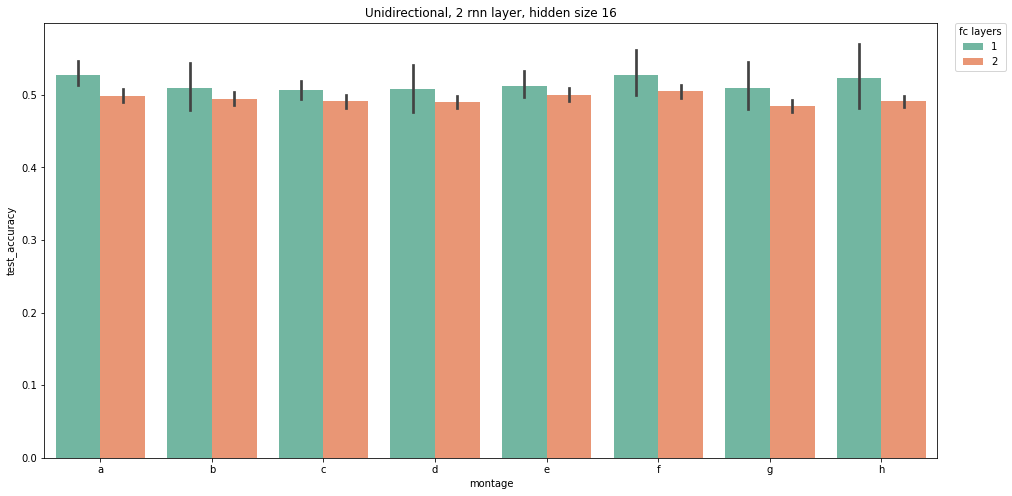

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=all_model_df[(~all_model_df['bidirectional']) & (all_model_df['rnn_layers'] == rnn_layers) & (all_model_df['hidden_size'] == hidden_size)],
            x='montage', y='test_accuracy', hue='fc_layers', palette='Set2', ax=ax, order=constants.MONTAGES)
plt.legend(title='fc layers', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'Unidirectional, {rnn_layers} rnn layer, hidden size {hidden_size}');

In [111]:
output_df = all_model_df[(~all_model_df['bidirectional']) &
                         (all_model_df['fc_layers'] == fc_layers) &
                         (all_model_df['rnn_layers'] == rnn_layers) & 
                         (all_model_df['hidden_size'] == hidden_size)].groupby('montage').mean()
output_df[test_cols + train_cols].round(3)

,test_accuracy,test_precision,test_recall,test_f1,train_accuracy,train_precision,train_recall,train_f1
montage,,,,,,,,
a,0.499,0.476,0.067,0.043,0.501,0.507,0.031,0.032
b,0.494,0.476,0.067,0.043,0.503,0.514,0.031,0.032
c,0.491,0.500,0.067,0.044,0.502,0.503,0.067,0.045
d,0.489,0.500,0.067,0.044,0.500,0.503,0.067,0.045
e,0.500,0.500,0.067,0.044,0.498,0.489,0.060,0.042
f,0.505,0.500,0.067,0.044,0.498,0.492,0.023,0.027
g,0.485,0.429,0.017,0.021,0.493,0.490,0.052,0.040
h,0.491,0.522,0.067,0.046,0.495,0.513,0.058,0.043


In [112]:
output_df = output_df[['hidden_size', 'rnn_layers', 'fc_layers',] + test_cols].round(3)
output_df.reset_index(inplace=True)
output_df.set_index = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
print(output_df.to_latex(index=False,
                         header=['Montage', 'Hidden Size', 'RNN Layers', 'FC Layers', 'Accuracy', 'Precision', 'Recall', 'F1']))

\begin{tabular}{lrrrrrrr}
\toprule
Montage & Hidden Size & RNN Layers & FC Layers & Accuracy & Precision & Recall &     F1 \\
\midrule
      a &        16.0 &        2.0 &       2.0 &    0.499 &     0.476 &  0.067 &  0.043 \\
      b &        16.0 &        2.0 &       2.0 &    0.494 &     0.476 &  0.067 &  0.043 \\
      c &        16.0 &        2.0 &       2.0 &    0.491 &     0.500 &  0.067 &  0.044 \\
      d &        16.0 &        2.0 &       2.0 &    0.489 &     0.500 &  0.067 &  0.044 \\
      e &        16.0 &        2.0 &       2.0 &    0.500 &     0.500 &  0.067 &  0.044 \\
      f &        16.0 &        2.0 &       2.0 &    0.505 &     0.500 &  0.067 &  0.044 \\
      g &        16.0 &        2.0 &       2.0 &    0.485 &     0.429 &  0.017 &  0.021 \\
      h &        16.0 &        2.0 &       2.0 &    0.491 &     0.522 &  0.067 &  0.046 \\
\bottomrule
\end{tabular}



## Train/Valid Losses

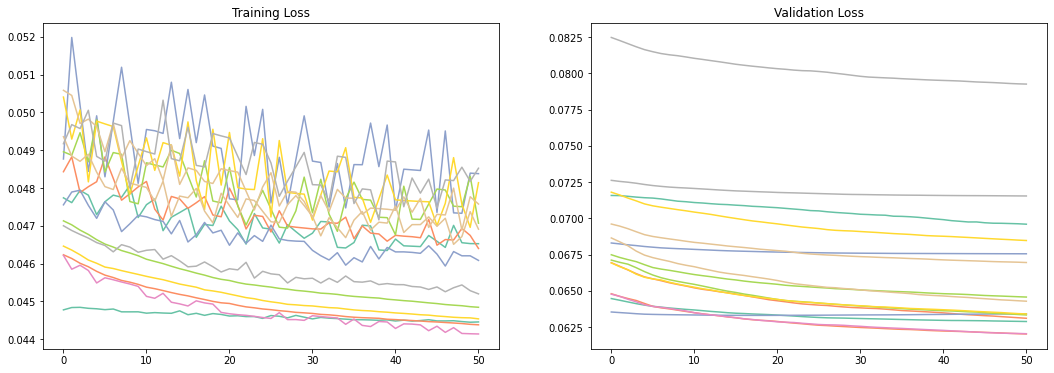

In [120]:
rnn_layers = 2
fc_layers = 2
hidden_size = 16
bidirectional = False
montage = 'e'

subset_df = all_model_df[(all_model_df['hidden_size'] == hidden_size) &
                         (all_model_df['rnn_layers'] == rnn_layers) & 
                         (all_model_df['fc_layers'] == fc_layers) & 
                         (all_model_df['bidirectional'] == bidirectional) & 
                         (all_model_df['montage'] == montage)]

n = len(subset_df)
colors = plt.cm.Set2(np.linspace(0, 1, n))

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
for i, idx in enumerate(subset_df.index):
    ax[0].plot(subset_df.loc[idx, 'train_losses'], color=colors[i])
    ax[1].plot(subset_df.loc[idx, 'valid_losses'], color=colors[i])
    ax[0].set_title('Training Loss')
    ax[1].set_title('Validation Loss')

## Bidirectional

In [97]:
rnn_layers = 1
fc_layers = 1
hidden_size = 16

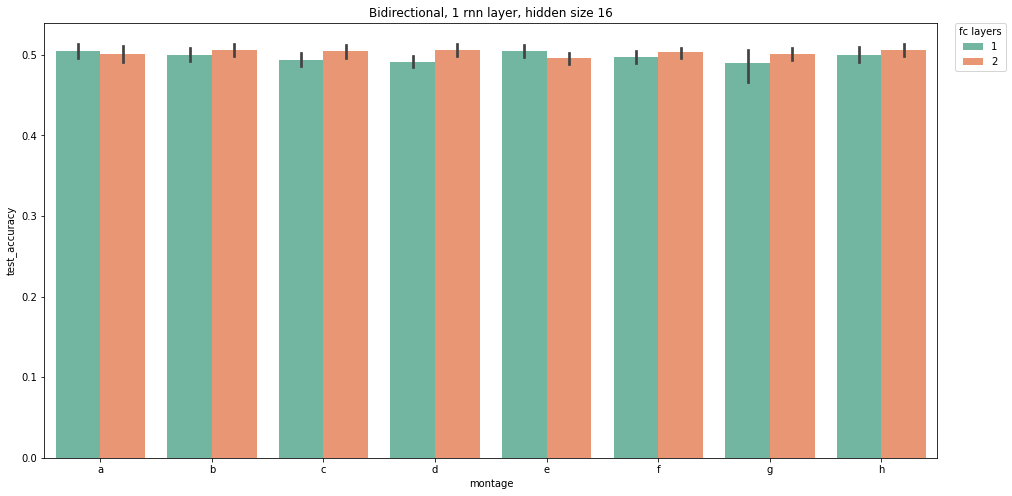

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=all_model_df[(all_model_df['bidirectional']) & (all_model_df['rnn_layers'] == rnn_layers) & (all_model_df['hidden_size'] == hidden_size)],
            x='montage', y='test_accuracy', hue='fc_layers', palette='Set2', ax=ax, order=constants.MONTAGES)
plt.legend(title='fc layers', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'Bidirectional, {rnn_layers} rnn layer, hidden size {hidden_size}');